# Navigation

1. Delete all unnecessary columns

2. Delete all entries with a neutral rating (overall = 3)

3. Binary Class "good" for "Positive" and "Negative" sentiment

4. Resample to obtain balanced dataset

5. Data Merging for Genre Attributes (dummy variables)

6. Add Personality & Grammar Features

7. Normalizing numerical features

8. Create interaction terms between movie genre and personality

9. Show descriptive statistics for variables

10. Use all features for a prediction model (Ridge Classifier, Neural Net)

In [ ]:
import pandas as pd
import os as os
import json as js
import gzip
import numpy as np
import matplotlib.pyplot as plt
import pickle

#importing libraries for NLP
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter

#Text Classification Material
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

In [ ]:
os.chdir("C:/Users/MAHAM/Desktop/Studium/Capstone Project/master__thesis")
os.getcwd()

# Data Preparation
### Merging Genre Data with Review Data

#### Review Data

In [ ]:
with open ('movies_data', 'rb') as fr:
    full_df = pickle.load(fr)

In [ ]:
full_df.shape

#### Genre Labels Data

In [ ]:
dfg = pd.DataFrame.from_csv("labels.csv",index_col=None)

In [ ]:
dfg = pd.DataFrame(dfg)

In [ ]:
dfg.head()

In [ ]:
dfg.shape

##### Deleting all rows where "Categories" is empty

In [ ]:
dfg = dfg[dfg["Categories"].map(len)!=2]

In [ ]:
dfg.shape

##### Keeping all Movies with the following ten Genres
- Comedy
- Art house and international
- Documentary
- Drama
- Action & Adventure
- Horror
- Science Fiction
- Animation
- Kids & Family
- Musicals

In [ ]:
dfg=dfg[dfg['Categories'].str.contains("Comedy|Art House and International|Documentary|Drama|Action & Adventure|Horror|Science Fiction|Animation|Kids & Family|Musicals")]

In [ ]:
dfg.head()

### Balancing the Genres by Undersampling

In [ ]:
genres=["Comedy","Art House & International","Documentary","Drama","Action & Adventure","Horror","Science Fiction","Animation","Kids & Family","Musicals"]
for genre in genres:
    count=len(dfg[dfg['Categories'].str.contains(genre)])
    print(genre,str(count))

##### As we can see, the rarest category here is Art House & International

In [ ]:
smallest_count=len(dfg[dfg['Categories'].str.contains("Art House & International")])
smallest_count

In [ ]:
genres_wo_art = ["Comedy","Documentary","Drama","Action & Adventure","Horror","Science Fiction","Animation","Kids & Family","Musicals"]


In [ ]:
# Divide by class
dfg_art = dfg[dfg['Categories'].str.contains("Art House & International")]
n=0
for genre in genres_wo_art:
    df_class_pos = dfg[dfg['Categories'].str.contains(genre)]
    df_class_pos_under = df_class_pos.sample(smallest_count, random_state=123)
    if n==0:
        df2= pd.concat([df_class_pos_under, dfg_art], axis=0)
    else:
        df2= pd.concat([df_class_pos_under, df2], axis=0)
    n+=1

#### Approximately equally large groups

In [ ]:
for genre in genres:
    count=len(df2[df2['Categories'].str.contains(genre)])
    print(genre,str(count))

In [ ]:
df2.head(3)

In [ ]:
df2.shape

##### Create list of 14360 selected movies 

In [ ]:
selected_movies=df2["ASIN"].values
len(selected_movies)

##### Reduces the number of entries from 1.7 million to around 78,000 

In [ ]:
full_df.shape

In [ ]:
df=full_df[full_df["asin"].isin(selected_movies)]
df.shape

#### Delete unused columns

In [ ]:
df.head(1)

In [ ]:
drop_columns=["reviewerName","helpful","summary","unixReviewTime","reviewTime"]
df = df.drop(columns=drop_columns)
df.head(1)

#### Balanced Dataset

##### Delete neutral reviews

In [ ]:
df.shape

In [ ]:
df = df[df.overall != 3]

In [ ]:
df.shape

In [ ]:
df = df.reset_index()
df = df.drop(columns="index")
df.shape

##### Create Binary Target Variable

In [ ]:
df["good"]=[1 if df.loc[i,"overall"]>=4 else 0 for i in range(len(df))]

##### Resample using **Undersampling**

In [ ]:
# without resampling 87% of the reviews are positive
df.good.mean()

In [ ]:
# Class count
count_pos, count_neg = df.good.value_counts()
count_pos,count_neg

In [ ]:
# Divide by class
df_class_pos = df[df['good'] == 1]
df_class_neg = df[df['good'] == 0]

df_class_pos_under = df_class_pos.sample(count_neg, random_state=123)
df= pd.concat([df_class_pos_under, df_class_neg], axis=0)

In [ ]:
# Balanced data set
df.good.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
df.good.mean(), df.shape

## Add Genre features to selected movies

In [ ]:
dfg=dfg.set_index("ASIN")
df = df.reset_index()
df = df.drop(columns="index")

In [ ]:
len(genres), genres

##### Produce ten dummy variables for each genre

In [ ]:
for genre in genres:
    df[genre]=0
    for row in range(len(df)):
        movie_id = df.loc[row,"asin"]
        if genre in dfg.loc[movie_id,"Categories"]:
            df.loc[row,genre]=1

In [ ]:
df.head()

### Genre Descriptions

In [ ]:
for genre in genres:
    count=df[genre].mean()
    print(genre,str(count))

In [ ]:
col_drop = ["Documentary","Musicals", "Kids & Family"]
df = df.drop(columns=col_drop)

In [ ]:
df.columns, df.good.mean()

### Add features
#### Grammar

In [ ]:
def feature_creator(feature, df):
    df[feature] = [df.loc[i, "reviewText"].count(feature)/((len(df.loc[i, "reviewText"]))+0.0001) for i in range(len(df))]

In [ ]:
dataframes=[df]
punc_marks = ("!","?",",","."," ")
for df in dataframes:
    # ADD FEATURE 1: Length of comment
    df["length"] = [len(df.loc[i, "reviewText"]) for i in range(len(df))]
    for f in punc_marks:
        # ADD FEATURE 2,3,4: Punctuation marks, and average word length (represented by whitespace/length)
        feature_creator(f, df)

In [ ]:
df.columns

In [ ]:
#import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [ ]:
# Add feature of Relative amount of word types
word_types=["noun", "adj", "verb (simple)","verb (simple past)", "verb (past participle)", "verb (gerund)", "adverb", "preposition"]
word_types_abb=["NN", "JJ","VB","VBD", "VBN", "VBG", "RB", "IN"]
word_types_dictionary={"noun":"NN", "adj":"JJ", "verb (simple)":"VB","verb (simple past)":"VBD", "verb (past participle)":"VBN", "verb (gerund)":"VBG", "adverb":"RB", "preposition":"IN"}
for wt in word_types:
    df[wt]=df["good"]
for i in range(len(df)):
    text = df.loc[i, "reviewText"]
    tokens = nltk.word_tokenize(text.lower())
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    counts = Counter(tag for word,tag in tags)
    total = sum(counts.values())
    count_dic = dict((word, float(count)/total) for word,count in counts.items())
    for wt, abb in word_types_dictionary.items():
        if abb in count_dic:
            df.iloc[i, df.columns.get_loc(wt)] = count_dic[abb]
        else:
            df.iloc[i, df.columns.get_loc(wt)] = 0 

In [ ]:
# normalizing the values
for col in word_types:
    df[col]=(df[col]-df[col].mean())/df[col].std()

#### Personality

In [ ]:
# Create column with text without puctuation for personality
df["text_plain"] = df['reviewText'].map(lambda x: re.sub('[^a-zA-Z]', ' ', x))

In [ ]:
import csv
letters = ["E", "A", "N", "O", "C"]
big5 = ["Extro", "Agree", "Neuro", "Open", "Consc"]
for df in dataframes:
    for column in big5:
        df[column]=df["overall"]
    for j,letter in enumerate(letters):
        reader = csv.reader(open('%s.top100.1to3grams.gender_age_controlled.rmatrix.csv'%(letter), 'r'))
        dic = {}
        for row in reader:
            k, v, z= row
            dic[k] = v
        dic.pop("")
        for i in range(len(df)):
            text = df.iloc[i, df.columns.get_loc("text_plain")]
            tokens = nltk.word_tokenize(text.lower())
            text = nltk.Text(tokens)
            word_value = 0
            for word, value in dic.items():
                counter = text.count(word)
                word_value = word_value+(counter*float(value))
            #current_length = len(df.columns)
            personality_number = word_value/((df.iloc[i,df.columns.get_loc("length")])+0.0001)
            df.iloc[i, df.columns.get_loc(big5[j])] = personality_number

In [ ]:
df = df.drop(columns="text_plain")

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15,6))
for i in range(3):
    axs[0,i].hist(df[big5[i]], bins=100)
    axs[0,i].set_title(big5[i])
for i in range(3,5):
    axs[1,i-3].hist(df[big5[i]], bins=100)
    axs[1,i-3].set_title(big5[i])

In [ ]:
big5 = ["Extro", "Agree", "Neuro", "Open", "Consc"]
het=pd.plotting.scatter_matrix(df[big5], c=df["overall"], figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 70}, s=60, alpha=.5)

In [ ]:
df.columns

In [ ]:
# Check how many users review more than once in this dataset
df.shape[0], len(set(df.reviewerID)),len(set(df.asin))

### Normalization

In [ ]:
# word types were already normalized above
numeric = ['Extro', 'Agree', 'Neuro', 'Open', 'Consc', 'length', '!', '?', ',','.', ' ']

In [ ]:
for col in numeric:
    df[col]=(df[col]-df[col].mean())/df[col].std()

## Interaction terms

In [ ]:
big5 = ["Extro", "Agree", "Neuro", "Open", "Consc"]
genres=["Comedy","Art House & International","Drama","Action & Adventure","Horror","Science Fiction","Animation"]
def create_interaction_terms(df):
    for personality in big5:
        for genre in genres:
            df[personality+"_"+genre]=df.apply(lambda x: x[personality]*x[genre], axis=1)

In [ ]:
create_interaction_terms(df)

In [ ]:
df.shape

In [ ]:
with open ('data_25_07', 'wb') as fw:
    pickle.dump(df, fw)

### Pre-Trained Sentiment Analyser

In [ ]:
df.columns

In [ ]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [ ]:
df["sentiment"]=df["reviewText"].map(lambda x :analyser.polarity_scores(x)["compound"])

In [ ]:
df.head(2)

In [ ]:
with open ('df_07_08', 'wb') as fw:
    pickle.dump(df, fw)

### END of Data Pre-Processing

# Feature Description

## Personality

In [2]:
with open ('df_07_08', 'rb') as fr:
    df = pickle.load(fr)

In [ ]:
personality = ["Extro", "Agree", "Neuro", "Open", "Consc"]
for pers in personality:
    print(pers)
    print(df["reviewText"].loc[df[pers].idxmax()])
    print(df["reviewText"].loc[df[pers].idxmin()],"\n")

In [ ]:
big5 = ["Extro", "Agree", "Neuro", "Open", "Consc"]
fig, axs = plt.subplots(2,3, figsize=(15,8))
fig.suptitle('Movie and TV Show Reviews')
for i in range(3):
    axs[0,i].hist(df[big5[i]], bins=100, color="maroon")
    axs[0,i].set_title(big5[i])
    axs[0,i].set_xlim(-10,10)
for i in range(3,5):
    axs[1,i-3].hist(df[big5[i]], bins=100, color="maroon")
    axs[1,i-3].set_title(big5[i])
    axs[1,i-3].set_xlim(-10,10)

In [ ]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline
used_col=personality+["good"]
df2=df[used_col]
sns.pairplot(df2, hue="good")

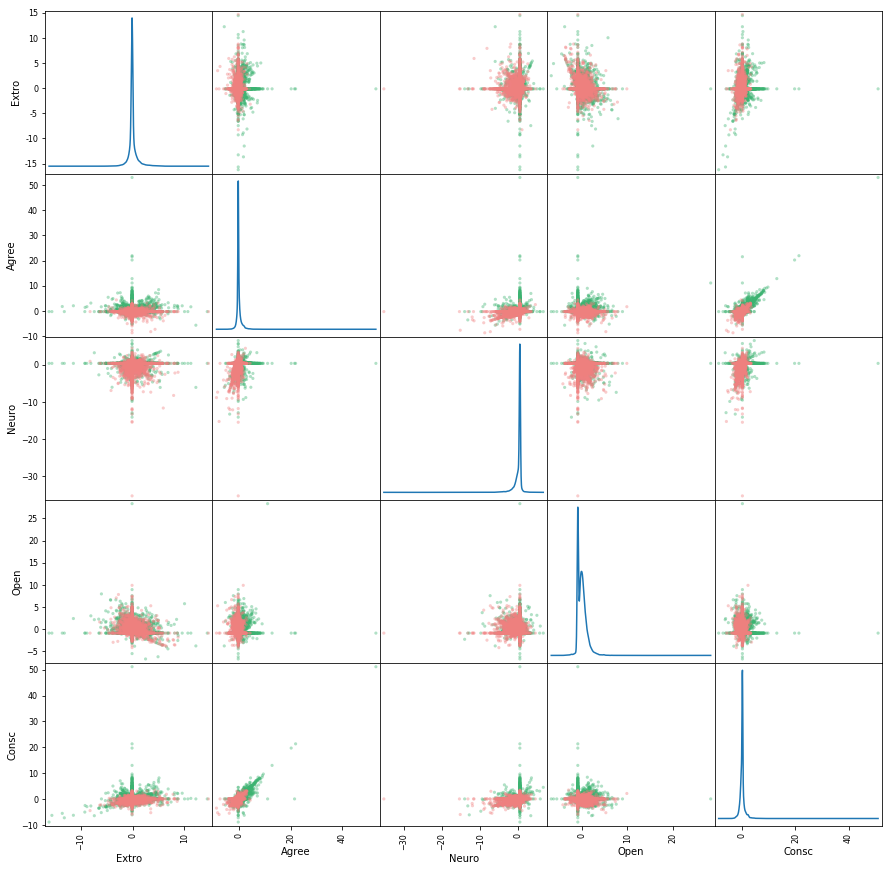

In [4]:
personality = ["Extro", "Agree", "Neuro", "Open", "Consc"]
colors = df['good'].replace({1:'mediumseagreen', 0: 'lightcoral'})   
het=pd.plotting.scatter_matrix(df[personality], c=colors, figsize=(15, 15), marker='o',
                                diagonal = 'kde',s=10, alpha=.4)

In [5]:
movies_2=df.copy(deep=False)
median_O = movies_2.loc[:,"Open"].median()
median_N = movies_2.loc[:,"Neuro"].median()

In [6]:
movies_2["high_O"] = [1 if movies_2.loc[i, "Open"]>=median_O else 0 for i in range(len(movies_2))]

unique_movies= movies_2.groupby(["asin"],as_index=False).mean()
movies_2=movies_2.reset_index()

In [9]:
import random
random.seed("Capstone")
movies_id = list(set(movies_2["asin"]))
#reviewers_Health = list(set(health_data["reviewerID"]))
#reviewers_Apps = list(set(apps_data["reviewerID"]))
movies_1000 = random.sample(movies_id, 1000)

In [11]:
d = {"Movie Title":movies_1000}
columns=["Movie Title",
         "Rating_H_O","Rating_L_O"]
unique = pd.DataFrame(data=d, index=range(1000),columns=columns)
unique.head()

,Movie Title,Rating_H_O,Rating_L_O
0,B0000AKCLL,NaN,NaN
1,B001FOPOD8,NaN,NaN
2,6301968018,NaN,NaN
3,1559409061,NaN,NaN
4,6300215350,NaN,NaN


In [12]:
#movies_2["rating_low_open"] 
for title in movies_1000:
    for letter in ["O"]:
        unique.loc[unique["Movie Title"]==title,"Rating_H_"+letter] = movies_2.loc[(movies_2.asin == title) & (movies_2["high_"+letter]==1),"overall"].mean()
        unique.loc[unique["Movie Title"]==title,"Rating_L_"+letter] = movies_2.loc[(movies_2.asin == title) & (movies_2["high_"+letter]==0),"overall"].mean()
        unique.loc[unique["Movie Title"]==title,"Number_H_"+letter] = movies_2[(movies_2["high_"+letter] == 1) & (movies_2.asin == title)].count()["index"]
        unique.loc[unique["Movie Title"]==title,"Number_L_"+letter] = movies_2[(movies_2["high_"+letter] == 0) & (movies_2.asin == title)].count()["index"]

for letter in ["O"]:
    unique["diff_"+letter]=unique["Rating_H_"+letter]-unique["Rating_L_"+letter]

In [14]:
#movies_2["rating_low_open"] 
for title in movies_1000:
    for letter in ["O"]:
        unique.loc[unique["Movie Title"]==title,"Rating_H_"+letter] = movies_2.loc[(movies_2.asin == title) & (movies_2["high_"+letter]==1),"overall"].mean()
        unique.loc[unique["Movie Title"]==title,"Rating_L_"+letter] = movies_2.loc[(movies_2.asin == title) & (movies_2["high_"+letter]==0),"overall"].mean()
        unique.loc[unique["Movie Title"]==title,"Number_H_"+letter] = movies_2[(movies_2["high_"+letter] == 1) & (movies_2.asin == title)].count()["index"]
        unique.loc[unique["Movie Title"]==title,"Number_L_"+letter] = movies_2[(movies_2["high_"+letter] == 0) & (movies_2.asin == title)].count()["index"]

for letter in ["O"]:
    unique["diff_"+letter]=unique["Rating_H_"+letter]-unique["Rating_L_"+letter]

In [16]:
unique["diff_O"]=unique["diff_O"].astype('float64')
unique_enough = unique[(unique["Number_H_O"]>30)&(unique["Number_L_O"]>30)&(unique["diff_O"]>1)]
unique_enough.head(20)
unique_enough.nlargest(5,"diff_O")

,Movie Title,Rating_H_O,Rating_L_O,Number_H_O,Number_L_O,diff_O


# Analysis

In [ ]:
with open ('data_26_07_w_corpus', 'rb') as fr:
    df = pickle.load(fr)

In [ ]:
df.columns[5:57]

## Linear Regression

In [ ]:
from sklearn import  linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = df.drop(columns="Animation")
X1 = X.iloc[:,5:57]
y = df["good"]

X2 = sm.add_constant(X1)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())


#grammar and personality model:
#0.087 adj r^2
#-12794
# 2.561e+04 aic
# 2.570e+04 bic

#grammar personality and genre:
#0.109 adj r^2
#-12559
# 2.515e+04 aic
# 2.530e+04 bic

#full model with interactions 
#5 bis 57:
#0.115 adj r^2
#-12473
# AIC:  2.505e+04
# BIC:  2.547e+04

In [ ]:
df.columns[5:12]

In [ ]:
df.good.mean()

In [ ]:
X = df.iloc[:,5:12]
y = df["good"]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

### Ridge Classifier

In [ ]:
X = df.iloc[:,5:]
y = df["good"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

In [ ]:
from sklearn.linear_model import RidgeClassifierCV

clf = RidgeClassifierCV(alphas=[1e-7,1e-6,1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test) 

In [ ]:
clf.alpha_

In [ ]:
d= {"Variable" : list(df.columns[5:]),"Coefficients":list(clf.coef_[0])}
results=pd.DataFrame(data=d)
results[1:]

In [ ]:
log = LogisticRegression(solver='liblinear')#regularization is applied by default
log.fit(X_train, y_train)
accuracy=log.score(X_test,y_test)

In [ ]:
accuracy

# Neural Nets

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
X = df.iloc[:,5:]
y = df["good"]
mlp = MLPClassifier(alpha=0.9,random_state=123)
mlp.fit(X_train, y_train)
score = mlp.score(X_test, y_test)
score

# Comparison with other methods

## VADER

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [ ]:
df["sentiment"]=df["reviewText"].map(lambda x :analyser.polarity_scores(x)["compound"])

In [ ]:
df["sentiment_binary"]=df["sentiment"]>0

In [ ]:
pd.crosstab(df["sentiment_binary"],df["good"])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df["sentiment_binary"],df["good"])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(df["sentiment_binary"],df["good"])

In [ ]:
het=pd.plotting.scatter_matrix(df[big5], c=df["overall"], figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 70}, s=60, alpha=.5)


### Creating User-Relative features 

In [ ]:
df_m_index=df_m.reset_index()
df_h_index=df_h.reset_index()
df_a_index=df_a.reset_index()

In [ ]:
users_mean_df_m=df_m.groupby(["reviewerID"],as_index=False).mean()
users_mean_df_m.shape

In [ ]:
users_mean_df_h=df_h.groupby(["reviewerID"],as_index=False).mean()
users_mean_df_a=df_a.groupby(["reviewerID"],as_index=False).mean()
users_mean_df_h.shape,users_mean_df_a.shape

In [ ]:
columns = big5
for column in columns:
        df_m_index[column+"_dm"]=df_m_index["good"]
        for user in unique_reviewer_IDs_m:
            indices = df_m_index.index[df_m_index['reviewerID'] == user].tolist()
            for index in indices:
                df_m_index.iloc[[index],df_m_index.columns.get_loc(column+"_dm")]=df_m_index.iloc[[index],df_m_index.columns.get_loc(column)]-(list(users_mean_df_m[users_mean_df_m["reviewerID"] == user][column])[0])

In [ ]:
for column in columns:
    df_h_index[column+"_dm"]=df_m_index["good"]
    for user in unique_reviewer_IDs_h:
        indices = df_h_index.index[df_h_index['reviewerID'] == user].tolist()
        for index in indices:
            df_h_index.iloc[[index],df_h_index.columns.get_loc(column+"_dm")]=df_h_index.iloc[[index],df_h_index.columns.get_loc(column)]-(list(users_mean_df_h[users_mean_df_h["reviewerID"] == user][column])[0])
                
for column in columns:
    df_a_index[column+"_dm"]=df_m_index["good"]
    for user in unique_reviewer_IDs_a:
        indices = df_a_index.index[df_a_index['reviewerID'] == user].tolist()
        for index in indices:
            df_a_index.iloc[[index],df_a_index.columns.get_loc(column+"_dm")]=df_a_index.iloc[[index],df_a_index.columns.get_loc(column)]-(list(users_mean_df_a[users_mean_df_a["reviewerID"] == user][column])[0])

In [ ]:
# Creating relative frequencies regarding each person
# by Substraction through personal mean
word_types=["noun", "adj", "verb (simple)","verb (simple past)", "verb (past participle)", "verb (gerund)", "adverb", "preposition"]
punc_marks = ["!","?",",","."," "]
columns= word_types+punc_marks
columns= columns+["length"]
df_index = [df_m_index,df_h_index,df_a_index]
df_mean = [users_mean_df_m, users_mean_df_h, users_mean_df_a]
unique_reviewer_IDs = [unique_reviewer_IDs_m,unique_reviewer_IDs_h,unique_reviewer_IDs_a]

In [ ]:
for i in range(3):
    for column in columns:
        df_index[i][column+"_rel_sub"]=df_index[i]["good"]
        for user in unique_reviewer_IDs[i]:
            indices = df_index[i].index[df_index[i]['reviewerID'] == user].tolist()
            for index in indices:
                df_index[i].iloc[[index],df_index[i].columns.get_loc(column+"_rel_sub")]=df_index[i].iloc[[index],df_index[i].columns.get_loc(column)]-(list(df_mean[i][df_mean[i]["reviewerID"] == user][column])[0])

# Comparison with Bag-of-Words

In [ ]:
with open ('genre_personality_24_07_P', 'rb') as fr:
    df = pickle.load(fr)

In [ ]:
df.head(2)

In [ ]:
df["corpus"] = df['reviewText'].map(lambda x: re.sub('[^a-zA-Z]', ' ', x))
#Making everything lowercase
df["corpus"] = df["corpus"].map(lambda x: x.lower())
#splitting the sentence into words
df["corpus"] = df["corpus"].map(lambda x: x.split())
ps = PorterStemmer()
# delete stop words and stemming the remaining words
df["corpus"] = df["corpus"].map(lambda x:[ps.stem(word) for word in x if not word in set(stopwords.words('english'))])
df["corpus"] = df["corpus"].map(lambda x: ' '.join(x))

In [ ]:
#with open ('data_26_07_w_corpus', 'wb') as fw:
#    pickle.dump(df, fw)

In [ ]:
with open ('data_26_07_w_corpus', 'rb') as fr:
    df = pickle.load(fr)

In [ ]:
median_O = df.loc[:,"Open"].median()
median_N = df.loc[:,"Neuro"].median()
median_A = df.loc[:,"Agree"].median()

# dataframe with high openness
df_H_O = df[df.Open >= median_O]
# df with low openness
df_L_O = df[df.Open < median_O]
# dataframe with high openness
df_H_N = df[df.Neuro >= median_N]
# df with low openness
df_L_N = df[df.Neuro < median_N]

# dataframe with high Agreeableness
df_H_A = df[df.Agree >= median_A]
# df with low Agreeableness
df_L_A = df[df.Agree < median_A]

In [ ]:
median_A, median_N, median_O

In [ ]:
import math
# df with random split
# reshuffle first
df = df.sample(frac=1).reset_index(drop=True)
half = math.ceil(len(df)/2)
df1 = df.iloc[:half,:]
df2 = df.iloc[half:,]

In [ ]:
dataframes = [df1,df2,df_H_O,df_L_O,df_H_N,df_L_N,df_H_A,df_L_A]
dataframes_names = ["df1","df2","df_H_O","df_L_O","df_H_N","df_L_N","df_H_A","df_L_A"]
for dfx, name in zip(dataframes,dataframes_names):
    print (name, dfx.shape)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# RELEVANT PART

In [ ]:
# df1 and df2 are random splits and df_H_O means High Openness, 
# df_L_O means low opennes etc, I split my median
dataframes = [df1,df2,df_H_O,df_L_O,df_H_N,df_L_N,df_H_A,df_L_A]
dataframes_names = ["df1","df2","df_H_O","df_L_O","df_H_N","df_L_N","df_H_A","df_L_A"]

In [ ]:
for dfx, name in zip(dataframes,dataframes_names):
    cv = CountVectorizer(max_features = 500, ngram_range=(1,2))
    XX = cv.fit_transform(dfx["corpus"]).toarray()
    # using relative word counts instead of absolute ones
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(XX).toarray()
    X = tfidf
    y=dfx["good"]
    acc=[]
    for seed in range(30):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = seed)
        log = LogisticRegression(solver='liblinear')#regularization is applied by default
        log.fit(X_train, y_train)
        accuracy=log.score(X_test,y_test)
        acc.append(accuracy)
    print(name," ",sum(acc)/len(acc), len(dfx))

# END

In [ ]:
from sklearn.linear_model import RidgeClassifierCV
#X = df.iloc[:,5:]
#y = df["good"]
clf = RidgeClassifierCV(alphas=[1e-7,1e-6,1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
clf.score(X_test, y_test) 

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
#X = df.iloc[:,5:]
#y = df["good"]
mlp = MLPClassifier(alpha=0.9,random_state=123)
mlp.fit(X_train, y_train)
score = mlp.score(X_test, y_test)
score